### Imports 

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('combinedplayerstats.csv')

In [3]:
# Fill missing values with None
df['Position_2'] = df['Position_2'].replace(np.nan, 'None')
df.head()

,Player,Nation,Squad,Age,90s,Non-penalty goals,Position,Position_2,League,Shot creation actions,...,Pass completion %,Tackles + interceptions,Shots blocked,Clearances,Dribbles attempted,Dribbles success %,Carries into penalty area,Passes received,Progressive passes received,Progressive carries
0,Brenden Aaronson,USA,Leeds United,25.0,7.1,0.02,FW,MF,Premier League,3.10,...,80.4,3.38,0.00,1.41,2.39,47.1,0.28,24.08,5.07,2.39
1,Jones El-Abdellaoui,MAR,Celta Vigo,19.0,1.1,0.00,MF,FW,La Liga,3.64,...,73.3,0.00,0.00,3.64,5.45,16.7,1.82,38.18,20.91,10.91
2,Himad Abdelli,ALG,Angers,25.0,5.9,0.00,MF,None,Ligue 1,2.88,...,84.0,3.22,0.51,1.02,3.05,38.9,0.00,48.31,1.69,3.90
3,Ali Abdi,TUN,Nice,31.0,2.8,0.00,DF,MF,Ligue 1,1.43,...,71.4,2.86,0.00,2.14,2.50,42.9,0.36,18.93,3.57,2.14
4,Salis Abdul Samed,GHA,Nice,25.0,3.9,0.00,MF,None,Ligue 1,0.51,...,91.2,2.05,0.00,0.51,0.77,33.3,0.26,33.85,0.77,0.51


In [4]:
# Drop all na rows
df = df.dropna().reset_index(drop=True)

df = df.drop_duplicates(subset=['Player']).reset_index(drop=True)
df['Player'].duplicated().sum()

0

In [5]:
# Filters
league = ['Premier League']


df = df[df['League'].isin(league)].reset_index(drop=True)




In [6]:
def preprocessor(df):
    df = df.drop(columns=['Nation','Squad','Position_2','Position','League'])
    player_names = df['Player'].tolist()
    df.drop(['Player'], axis=1, inplace=True)

    x = df.values
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    x_scaled_df = pd.DataFrame(x_scaled, columns=df.columns)

    pca = PCA(n_components=2)
    principal_components = pd.DataFrame(pca.fit_transform(x_scaled_df))

    return principal_components

In [7]:
def optimal_k(principal_components):
    distortions = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init ="auto", random_state=42)
        kmeans.fit(principal_components)
        distortions.append(sum(np.min(cdist(principal_components, kmeans.cluster_centers_, 'euclidean'), axis=1)) / principal_components.shape[0])

    diff =np.diff(distortions)
    diff_r = diff[1:] / diff[:-1]
    optimal_k = np.argmin(diff_r) + 2
    
    return optimal_k

In [8]:
def plot_elbow(principal_components):
    distortions = []
    K = range(1, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init ="auto", random_state=42)
        kmeans.fit(principal_components)
        distortions.append(sum(np.min(cdist(principal_components, kmeans.cluster_centers_, 'euclidean'), axis=1)) / principal_components.shape[0])
        
    diff =np.diff(distortions)
    diff_r = diff[1:] / diff[:-1]
    optimal_k = np.argmin(diff_r) + 2
    print(f'Optimal number of clusters: {optimal_k}')
    plt.figure(figsize=(10,6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

Optimal number of clusters: 6


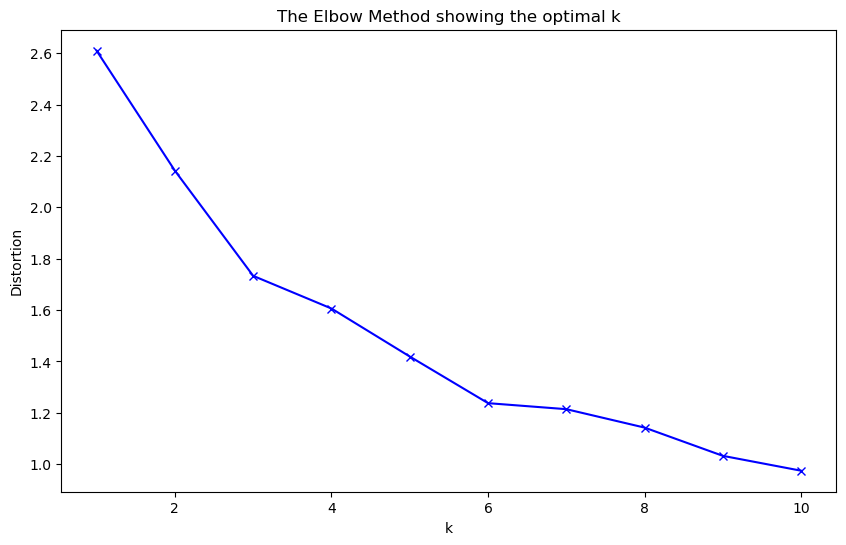

In [9]:
plot_elbow(preprocessor(df))

In [10]:
def concat_preprocessed(principal_components,df,optimal_k):
    kmeans =KMeans(n_clusters=optimal_k, n_init ="auto", random_state=42)
    kmeans.fit(principal_components)

    labels = kmeans.predict(principal_components)
    clusters = kmeans.labels_.tolist()

    player_names = df['Player'].tolist()

    principal_components['Cluster'] = clusters
    principal_components['Player'] = player_names
    principal_components.columns = ['x','y','Cluster','Player']

    principal_components = pd.merge(principal_components, df[['Player','Squad','League', 'Age', '90s', 'Nation']], on='Player', how='outer')

    return principal_components

In [11]:
def cluster(df):
    principal_components = preprocessor(df)
    optimal_k_value = optimal_k(principal_components)
    clustered_df = concat_preprocessed(principal_components, df, optimal_k_value)
    return clustered_df

In [12]:
cluster(df)

,x,y,Cluster,Player,Squad,League,Age,90s,Nation
0,-1.523281,-1.082836,5,Aaron Hickey,Brentford,Premier League,23.0,2.1,SCO
1,-1.068742,-0.285946,0,Aaron Wan-Bissaka,West Ham,Premier League,27.0,5.2,COD
2,-1.821632,-0.320242,5,Abdukodir Khusanov,Manchester City,Premier League,21.0,2.5,UZB
3,-1.604410,-0.910624,5,Adam Smith,Bournemouth,Premier League,34.0,2.3,ENG
4,0.271125,1.189568,0,Adam Wharton,Crystal Palace,Premier League,21.0,7.0,ENG
...,...,...,...,...,...,...,...,...,...
402,1.643829,0.373019,0,Yeremi Pino,Crystal Palace,Premier League,23.0,5.6,ESP
403,-1.066944,-0.890543,0,Yerson Mosquera,Wolves,Premier League,24.0,2.0,COL
404,-1.041267,2.916641,1,Youri Tielemans,Aston Villa,Premier League,28.0,3.5,BEL
405,0.567744,-3.280914,4,Zian Flemming,Burnley,Premier League,27.0,3.1,NED


### Calculating Distance: Row-normalized Euclidean Similarity

In [13]:
def distance_matrix(reduced):
    
    features = reduced[['x','y']].values

    distances = cdist(features, features, metric='euclidean')

    distance_df = pd.DataFrame(distances, index=reduced['Player'], columns=reduced['Player'])

    return distance_df

In [14]:
dist = distance_matrix(cluster(df))
dist

Player,Aaron Hickey,Aaron Wan-Bissaka,Abdukodir Khusanov,Adam Smith,Adam Wharton,Adama Traoré,Adrien Truffert,Alejandro Garnacho,Alex Iwobi,Alex Scott,...,Wilson Odobert,Xavi Simons,Yankuba Minteh,Yasin Ayari,Yehor Yarmoliuk,Yeremi Pino,Yerson Mosquera,Youri Tielemans,Zian Flemming,Álex Jiménez
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Hickey,0.000000,0.917409,0.818880,0.190365,2.895465,4.700581,2.188989,6.361797,4.009246,2.116689,...,3.832913,3.693842,5.524400,1.973442,1.046637,3.485699,0.495198,4.028418,3.033799,1.832792
Aaron Wan-Bissaka,0.917409,0.000000,0.753671,0.822899,1.993085,4.214319,1.284770,5.816673,3.111095,1.233638,...,3.221286,2.888842,5.064089,1.098114,0.129853,2.791465,0.604600,3.202705,3.412905,0.915735
Abdukodir Khusanov,0.818880,0.753671,0.000000,0.629077,2.580535,4.965098,1.693419,6.570309,3.688107,1.890986,...,3.973700,3.586379,5.813427,1.773100,0.840377,3.534124,0.945938,3.329621,3.804564,1.448454
Adam Smith,0.190365,0.822899,0.629077,0.000000,2.815749,4.762975,2.065143,6.413927,3.933394,2.049287,...,3.863263,3.665456,5.594219,1.909578,0.952341,3.492677,0.537841,3.868474,3.215047,1.727213
Adam Wharton,2.895465,1.993085,2.580535,2.815749,0.000000,3.327201,0.995868,4.613559,1.118595,0.791817,...,2.174397,1.229615,4.137264,0.938919,1.864134,1.597206,2.473316,2.169137,4.480312,1.132082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yeremi Pino,3.485699,2.791465,3.534124,3.492677,1.597206,1.730046,2.405987,3.113024,1.717364,1.766091,...,0.577300,0.693388,2.548209,1.832665,2.694255,0.000000,2.990798,3.698615,3.809092,2.295553
Yerson Mosquera,0.495198,0.604600,0.945938,0.537841,2.473316,4.225892,1.871015,5.879712,3.575583,1.683478,...,3.340235,3.211986,5.056417,1.537088,0.713883,2.990798,0.000000,3.807270,2.895873,1.478244
Youri Tielemans,4.028418,3.202705,3.329621,3.868474,2.169137,5.396774,2.004143,6.456923,2.294175,2.587295,...,4.266038,3.147475,6.154354,2.684544,3.097522,3.698615,3.807270,0.000000,6.403015,2.422341


### Calculating Distance: Relative Euclidean (Row wise)

In [15]:
def similarity_matrix(reduced, dist_matrix):
    sim_matrix = pd.DataFrame(index=reduced['Player'], columns=reduced['Player'])

    max_euclidean_dist = dist_matrix.max(axis=1)

    for i in range(len(dist_matrix)):
        for j in range(len(dist_matrix)):
            sim_matrix.iloc[i, j] = ((max_euclidean_dist.iloc[i] - dist_matrix.iloc[i, j]) * 100 / max_euclidean_dist.iloc[i])

    return sim_matrix

In [16]:
sim=similarity_matrix(cluster(df),dist)
sim

Player,Aaron Hickey,Aaron Wan-Bissaka,Abdukodir Khusanov,Adam Smith,Adam Wharton,Adama Traoré,Adrien Truffert,Alejandro Garnacho,Alex Iwobi,Alex Scott,...,Wilson Odobert,Xavi Simons,Yankuba Minteh,Yasin Ayari,Yehor Yarmoliuk,Yeremi Pino,Yerson Mosquera,Youri Tielemans,Zian Flemming,Álex Jiménez
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Hickey,100.0,95.149897,95.670798,98.993592,84.692435,75.14926,88.42739,66.366845,78.804169,88.80962,...,79.736395,80.471626,70.793943,89.566928,94.466702,81.57202,97.382019,78.702808,83.961099,90.310509
Aaron Wan-Bissaka,94.92855,100.0,95.833697,95.451003,88.982202,76.703193,92.897775,67.845357,82.801828,93.180435,...,82.192688,84.030446,72.005651,93.929613,99.282172,84.568749,96.657766,82.295409,81.133417,94.937805
Abdukodir Khusanov,95.629928,95.977923,100.0,96.642839,86.228593,73.503019,90.962818,64.936575,80.317873,89.908472,...,78.793764,80.860759,68.975788,90.53759,95.515202,81.139626,94.951861,82.230984,79.696383,92.270113
Adam Smith,98.991909,95.642273,96.668675,100.0,85.088983,74.777297,89.063874,66.034551,79.170405,89.14784,...,79.541788,80.589294,70.37538,89.887679,94.956804,81.504257,97.15182,79.514197,82.974468,90.853411
Adam Wharton,82.085225,87.668417,84.033755,82.578444,100.0,79.413995,93.838381,71.455062,93.079046,95.100885,...,86.546603,92.392144,74.401985,94.190736,88.466259,90.117791,84.697139,86.579153,72.279484,92.995602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yeremi Pino,77.510441,81.989609,77.19801,77.465421,89.694905,88.837832,84.476691,79.914923,88.919653,88.605268,...,96.275291,95.526298,83.559082,88.175738,82.616798,100.0,80.703518,76.136721,75.423926,85.189204
Yerson Mosquera,97.313314,96.719757,94.867832,97.081954,86.581076,77.072508,89.848846,68.099743,80.600747,90.866324,...,81.877625,82.573439,72.566515,91.660558,96.126841,83.773485,100.0,79.343733,84.288501,91.979818
Youri Tielemans,75.582304,80.587252,79.817965,76.551785,86.852081,67.288204,87.852167,60.862259,86.094175,84.317472,...,74.142002,80.922018,62.696242,83.728012,81.224803,77.581361,76.922761,100.0,61.189014,85.317319


In [17]:
def get_similar_players(similarity_matrix,df, player, top_k=10):
    sims = similarity_matrix.loc[player].sort_values(ascending=False)
    sims = sims[sims.index != player]  # drop self
    top = sims.head(top_k).reset_index()
    top.columns = ['Player', '% similarity']

    # merge metadata for context
    meta_cols = ['Player','Squad','League','Age','Nation','90s','Position']
    meta_cols = [c for c in meta_cols if c in df.columns]
    top = top.merge(df[meta_cols].drop_duplicates('Player'), on='Player', how='left')
    return top

In [18]:
get_similar_players(sim, df, 'Cole Palmer', top_k=15)

,Player,% similarity,Squad,League,Age,Nation,90s,Position
0,Cody Gakpo,98.976103,Liverpool,Premier League,26.0,NED,8.8,FW
1,Bryan Mbeumo,97.8082,Manchester Utd,Premier League,26.0,CMR,9.6,MF
2,Pedro Neto,96.04232,Chelsea,Premier League,25.0,POR,8.4,FW
3,Anthony Gordon,96.008696,Newcastle Utd,Premier League,24.0,ENG,5.1,FW
4,Sávio,95.511812,Manchester City,Premier League,21.0,BRA,3.9,MF
5,Omar Marmoush,95.202018,Manchester City,Premier League,26.0,EGY,1.8,FW
6,Jacob Murphy,94.751495,Newcastle Utd,Premier League,30.0,ENG,5.5,FW
7,Mohammed Kudus,94.645731,Tottenham,Premier League,25.0,GHA,9.7,FW
8,Adama Traoré,94.510744,Fulham,Premier League,29.0,ESP,2.6,FW
9,Jeremie Frimpong,94.246441,Liverpool,Premier League,24.0,NED,1.0,DF


### Calculating Distance: Inverse Euclidean (allows for a spread)

In [19]:
def ieuc_similarity(reduced, distance_matrix):
    similarity_matrix = 1 / (1 + distance_matrix)
    np.fill_diagonal(similarity_matrix.values, 0)

    return similarity_matrix*100

In [20]:
i_euclidean = ieuc_similarity(cluster(df),dist)

In [21]:
get_similar_players(ieuc_similarity(cluster(df),dist),df, 'Cole Palmer', top_k=15)

,Player,% similarity,Squad,League,Age,Nation,90s,Position
0,Cody Gakpo,87.313339,Liverpool,Premier League,26.0,NED,8.8,FW
1,Bryan Mbeumo,76.275521,Manchester Utd,Premier League,26.0,CMR,9.6,MF
2,Pedro Neto,64.035606,Chelsea,Premier League,25.0,POR,8.4,FW
3,Anthony Gordon,63.840536,Newcastle Utd,Premier League,24.0,ENG,5.1,FW
4,Sávio,61.090520,Manchester City,Premier League,21.0,BRA,3.9,MF
5,Omar Marmoush,59.492720,Manchester City,Premier League,26.0,EGY,1.8,FW
6,Jacob Murphy,57.312790,Newcastle Utd,Premier League,30.0,ENG,5.5,FW
7,Mohammed Kudus,56.823992,Tottenham,Premier League,25.0,GHA,9.7,FW
8,Adama Traoré,56.212113,Fulham,Premier League,29.0,ESP,2.6,FW
9,Jeremie Frimpong,55.051434,Liverpool,Premier League,24.0,NED,1.0,DF


### Cosine Similarity 

In [22]:
def calc_cosine(df):

    num_features = df.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(num_features)

    cos_matrix = cosine_similarity(X_scaled)
    cos_scaled = ((cos_matrix + 1) / 2) * 100  # Scale to 0-100
    np.fill_diagonal(cos_scaled, 0)

    cos_df = pd.DataFrame(cos_scaled, index=df['Player'], columns=df['Player'])

    return cos_df.round(2)

In [23]:
calc_cosine(df)

Player,Brenden Aaronson,Joshua Acheampong,Tyler Adams,Tosin Adarabioyo,Simon Adingra,Amine Adli,Emmanuel Agbadou,Nayef Aguerd,Ola Aina,Rayan Aït-Nouri,...,Chris Wood,Joe Worrall,Granit Xhaka,Yehor Yarmoliuk,Ryan Yates,Leny Yoro,Oleksandr Zinchenko,Joshua Zirkzee,Martín Zubimendi,Martin Ødegaard
Player,,,,,,,,,,,,,,,,,,,,,
Brenden Aaronson,0.00,38.81,43.93,14.79,68.30,66.41,23.17,20.53,31.84,55.32,...,64.79,48.97,41.92,45.18,39.66,28.07,31.88,52.19,36.99,51.05
Joshua Acheampong,38.81,0.00,63.79,72.24,38.56,39.51,68.40,75.69,48.94,55.18,...,50.62,46.15,48.12,59.44,72.67,72.21,54.91,57.16,67.90,43.96
Tyler Adams,43.93,63.79,0.00,69.63,20.79,46.62,67.24,64.09,57.38,56.31,...,48.54,53.60,65.56,81.83,65.14,72.71,62.40,43.52,79.20,40.84
Tosin Adarabioyo,14.79,72.24,69.63,0.00,21.62,29.84,71.79,76.77,69.14,63.80,...,33.81,56.54,60.57,52.43,62.13,81.99,72.62,43.35,78.78,48.83
Simon Adingra,68.30,38.56,20.79,21.62,0.00,63.35,23.76,27.07,35.82,45.16,...,62.35,46.89,26.09,38.39,35.08,33.32,22.36,47.78,20.91,32.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Leny Yoro,28.07,72.21,72.71,81.99,33.32,30.62,58.92,57.72,53.68,61.60,...,32.93,55.45,47.28,73.32,52.68,0.00,52.61,43.06,75.27,40.07
Oleksandr Zinchenko,31.88,54.91,62.40,72.62,22.36,47.98,70.77,73.48,66.06,64.81,...,25.45,43.58,76.91,45.84,64.04,52.61,0.00,46.49,79.36,83.99
Joshua Zirkzee,52.19,57.16,43.52,43.35,47.78,49.54,54.80,57.26,22.36,35.61,...,67.92,40.13,38.57,42.23,49.82,43.06,46.49,0.00,40.53,41.44


In [24]:
def top_cosine_players(df, player,top_k=10):
    cos_df = calc_cosine(df)
    if player not in cos_df.index:
        raise ValueError(f"{player} not found in dataset")

    # Extract the player's similarity row
    sims = cos_df.loc[player].sort_values(ascending=False)

    # Convert to dataframe
    top = sims.head(top_k).reset_index()
    top.columns = ['Player', '% similarity']

    # Attach player metadata (Squad, League, Age, etc.)
    meta_cols = ['Player','Squad','League','Age','Nation','90s','Position']
    meta_cols = [c for c in meta_cols if c in df.columns]
    top = top.merge(df[meta_cols].drop_duplicates('Player'),
                    on='Player', how='left')

    return top

In [25]:
top_cosine_players(df, 'Cole Palmer', top_k=15)

,Player,% similarity,Squad,League,Age,Nation,90s,Position
0,Jadon Sancho,91.08,Aston Villa,Premier League,25.0,ENG,0.8,FW
1,Wilson Odobert,83.60,Tottenham,Premier League,20.0,FRA,3.7,FW
2,Jamie Gittens,81.90,Chelsea,Premier League,21.0,ENG,2.7,FW
3,Amad Diallo,80.96,Manchester Utd,Premier League,23.0,CIV,7.4,DF
4,Rio Ngumoha,80.02,Liverpool,Premier League,17.0,ENG,0.4,FW
5,Federico Chiesa,79.82,Liverpool,Premier League,28.0,ITA,1.3,FW
6,Rodrigo Gomes,78.86,Wolves,Premier League,22.0,POR,3.7,FW
7,Samuel Chukwueze,78.70,Fulham,Premier League,26.0,NGA,0.5,FW
8,Florian Wirtz,78.51,Liverpool,Premier League,22.0,GER,6.7,MF
9,Emile Smith Rowe,78.26,Fulham,Premier League,25.0,ENG,2.5,MF


### Combining Euclidean Distance & Cosine Similarity to create our Similarity Score

In [26]:
def calc_score(cos_matrix, eucl_matrix, alpha=0.6):
    
    common = cos_matrix.index.intersection(eucl_matrix.index)
    cos = cos_matrix.loc[common, common]
    eucl = eucl_matrix.loc[common, common]

    score = alpha * cos + (1 - alpha) * eucl    
    np.fill_diagonal(score.values, 0)

    return score.round(2)

In [27]:
sim_score=calc_score(calc_cosine(df), ieuc_similarity(cluster(df),dist))

In [28]:
def final_similar(sim_matrix,player, top_k=10, df_meta=None):
    row = sim_matrix.loc[player].drop(player,errors='ignore')

    top = row.sort_values(ascending=False).head(top_k).reset_index()
    top.columns = ['Player', 'Similarity Score %']

    if df_meta is not None:
        keep = [c for c in ['Player','Squad','League','Age','Nation','90s','Position'] if c in df_meta.columns]
        if keep:
            top = top.merge(df_meta[keep].drop_duplicates('Player'), on='Player', how='left')

    return top

In [29]:
final_similar(sim_score, 'Cole Palmer', top_k=15, df_meta=df)

,Player,Similarity Score %,Squad,League,Age,Nation,90s,Position
0,Cody Gakpo,77.10,Liverpool,Premier League,26.0,NED,8.8,FW
1,Bryan Mbeumo,74.33,Manchester Utd,Premier League,26.0,CMR,9.6,MF
2,Sávio,71.08,Manchester City,Premier League,21.0,BRA,3.9,MF
3,Pedro Neto,69.93,Chelsea,Premier League,25.0,POR,8.4,FW
4,Amad Diallo,69.24,Manchester Utd,Premier League,23.0,CIV,7.4,DF
5,Anthony Gordon,68.72,Newcastle Utd,Premier League,24.0,ENG,5.1,FW
6,Omar Marmoush,68.63,Manchester City,Premier League,26.0,EGY,1.8,FW
7,Jamie Gittens,68.61,Chelsea,Premier League,21.0,ENG,2.7,FW
8,Callum Hudson-Odoi,67.21,Nott'ham Forest,Premier League,25.0,ENG,6.3,FW
9,Wilson Odobert,67.06,Tottenham,Premier League,20.0,FRA,3.7,FW
